In [188]:
"""
FOR SCHWINGER
-Build all physical state
- Calculate dimensionality of Hphys
- Calculate the ground state
- Compagre ground state to microQLM




"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [189]:
S = 1

N = 6

In [296]:

def recursion(j,Nprec, Bs, Nlevel, states,N=5,Ninit=0,periodic = False):
    Bnew = 0
    Nnew = Nprec
    Bsnext = Bs.copy()
    Bsnext.append(Bnew)
    if j == N-1:
        Bsnext.append(Ninit)
        if periodic:
            if Nnew == Ninit:
                states.append(Bsnext)
        else:
            states.append(Bsnext)

    else:
        recursion(j+1,Nnew,Bsnext,Nlevel,states,N,Ninit,periodic)

    Bnew = 1
    Nnew = Nprec + (-1)**j
    if Nnew >= 0 and Nnew <=Nlevel:
        Bsnext = Bs.copy()
        Bsnext.append(Bnew)
        if j == N-1:
            Bsnext.append(Ninit)
            if periodic:
                if Nnew == Ninit:
                    states.append(Bsnext)
            else:
                states.append(Bsnext)
        else:
            recursion(j+1,Nnew,Bsnext,Nlevel,states,N,Ninit,periodic)


def getAllStatesPeriodic(N = 4,S = 1):
    states=[]

    Nlevel = int(2*S)
    for Ninit in range(0,Nlevel+1):
        recursion(0,Ninit,[],Nlevel,states,N,Ninit, True)

    return np.array(states)




In [297]:
states = getAllStatesPeriodic(N,S)


In [192]:
def printConfig(fermion,spin):
    color = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE", "#A2142F"]
    N = len(fermion)
    xs = np.arange(N+1)-0.5
    xfnot = np.squeeze(np.argwhere(fermion-1)) 
    xf = np.squeeze(np.argwhere(fermion)) 

    
    plt.plot(xs,spin)

    plt.plot(xf,np.zeros(len(xf)), "o",
            markersize=8,
            markeredgewidth=1.5,
            markeredgecolor=color[1],
            markerfacecolor=color[1])

    plt.plot(xfnot,np.zeros(len(xfnot)),"o",
            markersize=8,
            markeredgewidth=1.5,
            markeredgecolor=color[0],
            markerfacecolor=(1, 1, 0, 0.0))
    
    plt.show()


def getField(Sinit,state):
    field = np.zeros(len(state)+1)
    field[0] = Sinit
    Scurrent = Sinit
    for i,x in enumerate(state):
        Snext = Scurrent + (-1)**i * x
        field[i+1] = Snext
        Scurrent = Snext
    return field

def getAllFields(states):
    fields = np.zeros((len(states),len(states[0])))
    for i, state in enumerate(states):
        fields[i] = getField(state[-1]-S, state[:-1])
    return fields





def stateToFermion(state):
    N = len(state)-1
    x = np.arange(N)%2
    return (state[:-1]+x) %2


def statesToFermions(states):
    dim = len(states)
    N = len(states[0])-1

    x = np.repeat( [np.arange(N)%2], dim, axis=0)

    return((states[:,:-1]+x) %2)



k = 0
fields = getAllFields(states)
print(fields[k])
fermions = statesToFermions(states)
print(fermions[k])

[-1. -1. -1. -1. -1. -1. -1.]
[0 1 0 1 0 1]


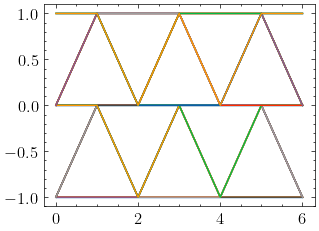

In [194]:
plt.plot(np.transpose(fields)) #plot all Hphys
plt.show()

In [195]:
#construct dim(H)vsN graph

Nmax = 24
S = 1
x = np.arange(2,Nmax,2)


dimFull = x * np.log((4*S+2))
dimPhys = np.zeros(len(x))

for i,n in enumerate(x):
    states = getAllStatesPeriodic(n,S)  #construct all states of size n
    dimPhys[i] = len(states)            #count them



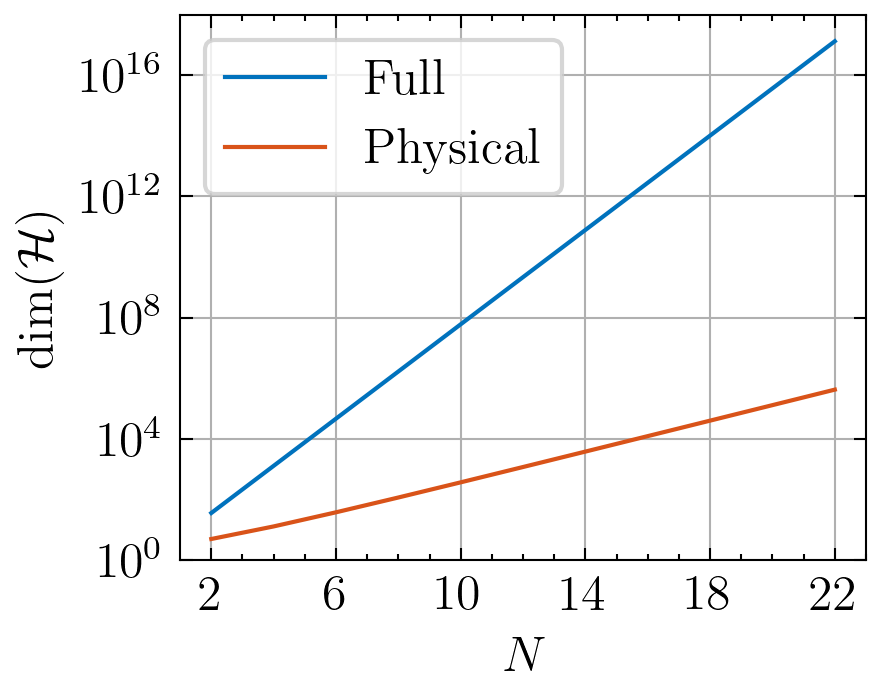

In [293]:
plt.style.use(["science"])
color = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE", "#A2142F"]

cm = 1 / 2.54
maxsize = 5.9

fig= plt.figure(figsize=(0.5*maxsize, 6 * cm), dpi=300)
ax=plt.gca()    
#plt.tight_layout()
plt.plot(x,np.exp(dimFull),'-',color=color[0], label="Full")
plt.plot(x,dimPhys,'-',color=color[1], label="Physical")
plt.rcParams["font.size"] = "12"
plt.ylabel(r"dim$(\mathcal{H})$", fontsize=12)
plt.xlabel(r"$N$", fontsize=12)

plt.xticks(x[::2])
#plt.yticks([-0.5,-0.25,0,0.25,0.5],["$-1/2$","","$0$","","$1/2$"])

#plt.xlim([-0.5,N-0.5])
plt.ylim([1,1e18])

#plt.tick_params(left = False,top=False,right=False) 
#plt.minorticks_off()
plt.grid()
plt.legend(frameon=True)
plt.yscale("log")
#plt.savefig("IMG/dimH.png", bbox_inches="tight")
plt.show()

In [196]:
def findField(fields,f):        #search a field config in all possible
    dim = len(fields)
    index =[]
    for i in range(dim):
        if np.allclose(fields[i],f):
            index.append(i)
    if len(index) == 1:
        return index[0]
    print("mh problem find fields")
    return index


def createHamiltonian(fermionsStates,spinsStates, t = 1 , m = 0.2 , g = 1,df = -1): #generate hamiltonian of the subsystem

    dim = len(fermionsStates)
    N = len(fermionsStates[0])

    x = (-2 * (np.arange(N)%2) +1)

    H = np.zeros((dim,dim))

    for i in tqdm(range(dim)):
        H[i,i] += 0.5*g**2 * np.sum(spinsStates[i,1:]**2)   # g term
        
        H[i,i] += m * np.sum(fermionsStates[i]*x)   # m term

        H[i,i] += df * np.sum(fermionsStates[i])    # boundarie dF term
        H[i,i] += - df * fermionsStates[i,0]        # dF term
        H[i,i] += - df * fermionsStates[i]@  np.diag(np.ones(N-1),k=1)  @fermionsStates[i]  # dF term
        
        for n in range(N):      # hopping term
            y = np.zeros(N)
            y[n] = -1
            y[(n+1)%N] = 1
            if np.sum(y * fermionsStates[i]) == 1 and spinsStates[i][(n+1)%N] <=S-1:
                f = spinsStates[i].copy()
                if n == N-1:
                    f[(n+1)] += 1
                f[(n+1)%N] += 1 
                j = findField(spinsStates,f)
                H[j,i] += -t
                H[i,j] += -t
    return(H)


In [197]:
S = 1./2
Sinit=-1./2

N = 6
states=[]

Nlevel = int(2*S)
Ninit = Sinit + S

states = getAllStatesPeriodic(N,S)



fields = getAllFields(states)
fermions = statesToFermions(states)
print(fermions)
print(fields)

[[0 1 0 1 0 1]
 [0 1 0 1 1 0]
 [0 1 1 1 0 0]
 [0 1 1 0 0 1]
 [0 1 1 0 1 0]
 [1 1 0 1 0 0]
 [1 1 0 0 0 1]
 [1 1 0 0 1 0]
 [1 0 0 1 0 1]
 [1 0 0 1 1 0]
 [1 0 1 1 0 0]
 [1 0 1 0 0 1]
 [1 0 1 0 1 0]
 [0 1 0 1 0 1]
 [0 1 0 0 1 1]
 [0 0 0 1 1 1]
 [0 0 1 1 0 1]
 [0 0 1 0 1 1]]
[[-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5  0.5  0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  0.5  0.5  0.5  0.5  0.5 -0.5]
 [-0.5  0.5  0.5  0.5 -0.5 -0.5 -0.5]
 [-0.5  0.5  0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  0.5  0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5 -0.5  0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5 -0.5  0.5  0.5]
 [ 0.5  0.5 -0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5 -0.5  0.5 -0.5  0.5  0.5]]


In [204]:
t = 0.05
g = (t * 2**0.5 )**0.5
m = 0.2#g**2
df = 0#-0.05
H = createHamiltonian(fermions, fields,t,m,g,df)

100%|██████████| 18/18 [00:00<00:00, 837.36it/s]


In [205]:
Energie,P = np.linalg.eigh(H)   # diagonalize H

array([-0.69129297, -0.08515829, -0.0025622 , -0.08515829, -0.01072226,
       -0.08515829, -0.0025622 , -0.01072226, -0.08515829, -0.01072226,
       -0.01072226, -0.01072226, -0.00263991, -0.69129297, -0.08515829,
       -0.0025622 , -0.08515829, -0.01072226])

[-0.007488634931153121, 0.007488634925035124, -0.007488634931153114, 0.007488634925035143, -0.007488634931153114, 0.007488634925035124, -0.007488634931153121]


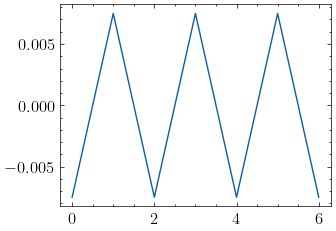

In [206]:
def E(state,fields):        # get electric field from a state in Hphys
    return np.einsum('i,in->n', np.absolute(state)**2, fields)

#plt.plot(E(P[:,0],fields))
#print(E(P[:,0],fields).tolist())

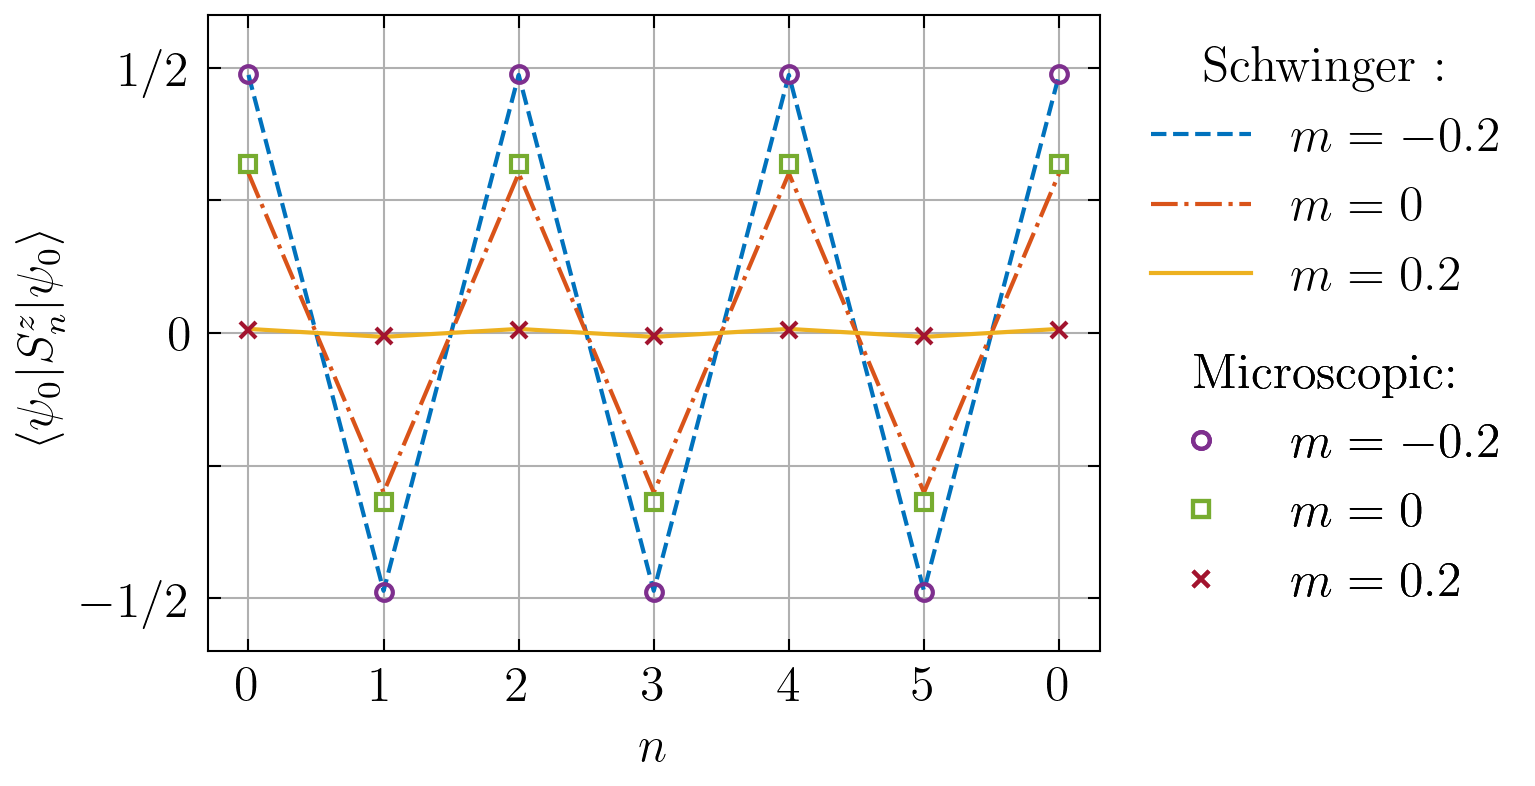

In [295]:
EQLM = np.array([[-0.4862642668783744, 0.48626426687837426, -0.4862642668783744, 0.4862642668783743, -0.4862642668783744, 0.48626426687837426, -0.4862642668783744],
                 [-0.3007033,  0.3007033, -0.3007033,  0.3007033, -0.3007033,  0.3007033, -0.3007033],
                 [-0.007488634931153121, 0.007488634925035124, -0.007488634931153114, 0.007488634925035143, -0.007488634931153114, 0.007488634925035124, -0.007488634931153121]])

EQLM = np.roll(EQLM,-1,axis=1)
EQLM[:,-1] = EQLM[:,0]

Emicro = np.array([[-0.48817551983948915, 0.48817551983948765, -0.48817551983948865, 0.48817551983948626, -0.48817551983949004, 0.4881755198394884, -0.48817551983948915],
                   [-0.3184325415808642, 0.318432541580562, -0.31843254158073486, 0.31843254158056933, -0.31843254158071876, 0.31843254158057477, -0.3184325415808642],
                   [-0.006006096409912454, 0.006006095954020518, -0.00600609640991423, 0.006006095954020907, -0.006006096409914341, 0.006006095954020602, -0.006006096409912454]])


Emicro = np.roll(Emicro,-1,axis=1)
Emicro[:,-1] = Emicro[:,0]

plt.style.use(["science"])
color = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE", "#A2142F"]

cm = 1 / 2.54
maxsize = 5.9

fig= plt.figure(figsize=(0.65*maxsize, 7 * cm), dpi=300)
ax=plt.gca()    

lw=1

QLM1, = plt.plot(EQLM[0],'--',label="$m=-0.2$",color=color[0],linewidth=lw)
QLM2, = plt.plot(EQLM[1],'-.',label="$m=0$",color=color[1],linewidth=lw)
QLM3, = plt.plot(EQLM[2],'-',label="$m=0.2$",color=color[2],linewidth=lw)
legend2 = plt.legend([QLM1,QLM2,QLM3], ["$m=-0.2$", "$m=0$", "$m=0.2$"],title="Schwinger :",bbox_to_anchor =(1.5,0.75), loc='right')
#pyplot.legend([l[0] for l in plot_lines], parameters, loc=4)
fig.add_artist(legend2)

ms=4
micro1, = plt.plot(Emicro[0],'o',label="$m=-0.2$",markersize=ms,
            markeredgewidth=lw,
            markeredgecolor=color[3],
            markerfacecolor=(1, 1, 0, 0.0))

micro2, = plt.plot(Emicro[1],'s',label="$m=0$",markersize=ms,
            markeredgewidth=lw,
            markeredgecolor=color[4],
            markerfacecolor=(1, 1, 0, 0.0))
micro3, = plt.plot(Emicro[2],'x',label="$m=0.2$",markersize=ms,
            markeredgewidth=lw,
            markeredgecolor=color[6])

legend1 = plt.legend([micro1,micro2,micro3], ["$m=-0.2$", "$m=0$", "$m=0.2$"], title="Microscopic:",bbox_to_anchor =(1.5,-0.0), loc='lower right')

fig.add_artist(legend1)






#plt.tight_layout()


plt.rcParams["font.size"] = "12"
plt.ylabel(r"$\langle\psi_0|S^z_n|\psi_0\rangle$", fontsize=12)
plt.xlabel(r"$n$", fontsize=12)

plt.xticks(np.arange(7),["$0$","$1$","$2$","$3$","$4$","$5$","$0$"])
plt.yticks([-0.5,-0.25,0,0.25,0.5],["$-1/2$","","$0$","","$1/2$"])

#plt.xlim([-0.5,N-0.5])
plt.ylim([-0.6,0.6])

#plt.tick_params(left = False,top=False,right=False) 
plt.minorticks_off()
plt.grid()
#plt.legend(frameon=True)

#plt.savefig("IMG/groundState.png", bbox_inches="tight")
plt.show()